<a href="https://colab.research.google.com/github/vladimirclaps/DataAnalyticsPortfolio/blob/main/Stock_Market_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Stock Market Exploratory Data Analysis (EDA)**

A lot of people have different conceptions of the stock market. Some want to become millionaires over night. Some have lost all their investments and sworn never to touch a stock again. Others understand that it is a good way to generate wealth overtime.

I believe that the stock market is a very powerfull tool that should be exploited by people. 

To provide some context, investing 500 USD per month during 35 years (ages 25 to 60) will net you on average by the end of the period close to 1MM USD (yes, one million dollars). See what i mean by powerfull tool?

I think it is worth exploring having a retirement savings where you just invest and forget about the price action and volatility.

This strategy is called buy & hold. In this notebook we will attempt to explore the patterns and caveats of the buy & hold strategy and understand if there are reliable ways to consistently beat it.

Using data from the S&P 500 index (biggest 500 companys of the USA, usually accepted as a proxy for 'the market') we will:

0.   Understand the risks and pay offs of a buy & hold strategy over different time horizons.

1.   Search for seasonality in particular days of the week and months.

2.   Test if trading the price patterns pays off consistently over time.

3.   Understand the risks and rewards of bear and bull markets.

4.   Draw conclusions and final remarks. 

The key word here is consistency and time. To create wealth over time you need to take out emotion off the equation and understand that timing may be not be as important in the long run.

We begin by installing yahoo finance and importing all necessary libraries.

In [ ]:
!pip install yfinance
!pip install matplotlib --upgrade

import math
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

Then we download data for the S&P 500 index (in this case '^GSPC'), we set our start and end dates for the data and we check for nulls and see the shape of our data.

In [ ]:
#We set the parameters for our request and download the data
stocks = ['^GSPC']
start = '1928-01-01'
end =  datetime.now()

df = yf.download(stocks, start=start, end=end, group_by='ticker')
df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23719 entries, 1928-01-03 to 2022-06-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23719 non-null  float64
 1   High       23719 non-null  float64
 2   Low        23719 non-null  float64
 3   Close      23719 non-null  float64
 4   Adj Close  23719 non-null  float64
 5   Volume     23719 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.3 MB


Before we begin i will quickly demonstrate the different savings you end up with, according to how much you invested over time.

In [ ]:
#We create a new dataframe with the monthly prices
investment = pd.DataFrame()
investment['Price'] = df['Adj Close'].asfreq('BM').ffill()

#we deflact the market by our investments and the compute the rolling sum 
test = [100,250,500,1000]
period = 35
mean_final_investment = []
for item in test:
  investment[item] =  item / investment['Price']
  investment[item] = investment[item].rolling(period*12).sum()
  investment[item] = investment[item] * investment['Price']
  fi = investment[item].mean()
  mean_final_investment.append(fi)

ret = ((mean_final_investment[0]/(test[0]*(period*12))-1)*100)
print(f"For a {period} year of monthly investing, the total return is {ret:,.0f}%, {(((1+ret/100)**(1/period))-1)*100:,.1f}% annually")
for i in range(0,len(test)):
  print(f"For {test[i]} monthly investments : ${mean_final_investment[i]:,.0f}, with an initial investment of ${test[i]*(period*12):,.0f}")

For a 35 year of monthly investing, the total return is 366%, 4.5% annually
For 100 monthly investments : $195,717, with an initial investment of $42,000
For 250 monthly investments : $489,293, with an initial investment of $105,000
For 500 monthly investments : $978,585, with an initial investment of $210,000
For 1000 monthly investments : $1,957,171, with an initial investment of $420,000


So, now that i caught your attention and you want to be rich, let's get started.

Note: this mean returns assume you always invest the last workday of the month, it is done this way for simplicity, the results should hold independently of the day.

# **0. Buy & Hold**

We will create a new dataframe that includes 1, 2, 5, 10, 20, 30 and 40 years returns, as well as daily, weekly and monthly returns to test how different holding periods impact the probability of having better results.

In [ ]:
period_return =pd.DataFrame()
tags = ['1 Day', '1 Week', '1 Month', '1 Year', '2 Year', '5 Year', '10 Year', '20 Year', '30 Year', '40 Year']
periods = [1, 5, 20, 250, 500, 1250, 2500, 5000, 7500, 10000]
for i in range(0,len(tags)):
  period_return[tags[i]] =  df['Adj Close'].pct_change(periods = periods[i])
period_return

,1 Day,1 Week,1 Month,1 Year,2 Year,5 Year,10 Year,20 Year,30 Year,40 Year
Date,,,,,,,,,,
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,-0.002252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,-0.009594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,0.006268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-09,-0.009060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-27,0.024742,0.065844,0.006367,-0.011853,0.336045,0.711640,2.137087,3.905031,8.869085,33.187621
2022-05-31,-0.006274,0.039862,-0.005590,-0.014477,0.293751,0.693261,2.095197,4.040129,8.881035,33.314482
2022-06-01,-0.007483,0.040530,-0.017782,-0.030417,0.268792,0.682266,2.121845,4.141319,8.805456,32.624907


It is important to keep in mind two things before we move on:


1.   We loose part of our data in some columns building the returns, we need to keep in mind the difference in observations and nulls when exploring*.
2.   Right now all the returns are for different time periods, so they are not comparable, we will now procede to transform all returns to annual returns.

*Here arises the following problem, we either have the same number of observations for each column, or we contemplate the same investing periods. In this particular case i prefer to have a mismatch in the number of observations because i believe it's important to take into account the same time periods, as our calculations are sensitive to returns.

In [ ]:
for x in range(0,len(tags)):
  counter = 0
  for i in range(0, len(period_return)):
    if math.isnan(period_return.iloc[i,x]):
      pass
    else:
      period_return.iloc[i,x] = ((1 + period_return.iloc[i,x]) ** (365/(period_return.index[i]-period_return.index[counter]).days))-1
      counter += 1

period_return

,1 Day,1 Week,1 Month,1 Year,2 Year,5 Year,10 Year,20 Year,30 Year,40 Year
Date,,,,,,,,,,
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,-0.560896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,-0.970359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,8.782766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-09,-0.669558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-27,7486.666816,26.798423,0.086261,-0.012050,0.157731,0.114472,0.121935,0.083330,0.079877,0.093078
2022-05-31,-0.436924,4.949883,-0.068127,-0.014596,0.138442,0.111853,0.120312,0.084800,0.079898,0.093160
2022-06-01,-0.935525,5.127032,-0.202144,-0.030665,0.127705,0.110396,0.121349,0.085886,0.079620,0.092601


Now we can start exploring, we should note that in the 1 day and 1 week columns big values should be expected.

At this point we should 'search & destroy' outliers to see tendencies, however i prefer to look at the entire data because if big swings in wealth can happen, i'd rather take it into account on the analysis.

Let's take a quick look at our return's distribution before we go any further.

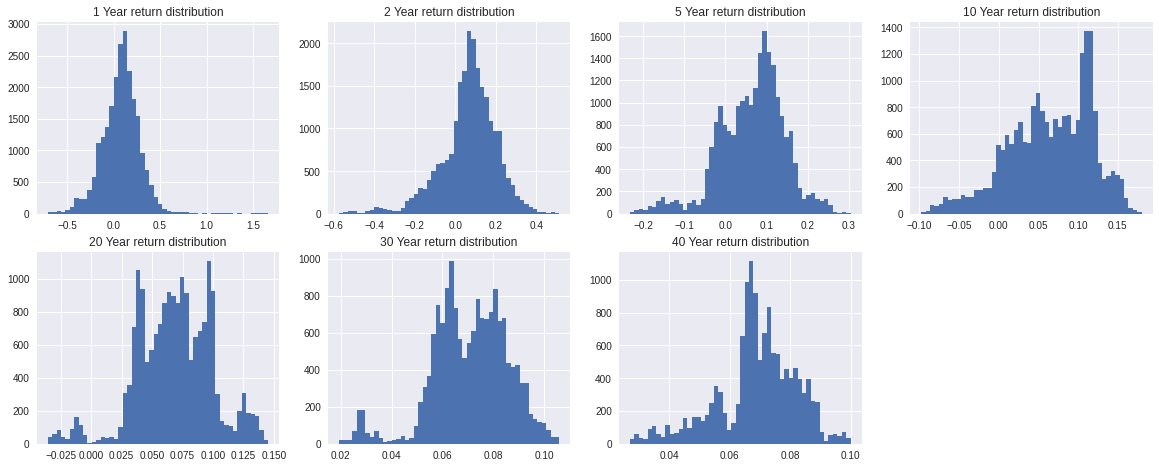

In [ ]:
plt.figure(figsize=(20, 12))
plt.style.use('seaborn')
for i in range(3,len(tags)):
  plt.subplot(3,4,i-2)
  period_return[tags[i]].hist(bins = 50)
  plt.title(f"{tags[i]} return distribution")

Okay, so apparently the longer holding periods are centered towards higher returns.

Let's investigate this a bit further.

Text(0.5, 1.0, 'Min/Max Return for Holding Period')

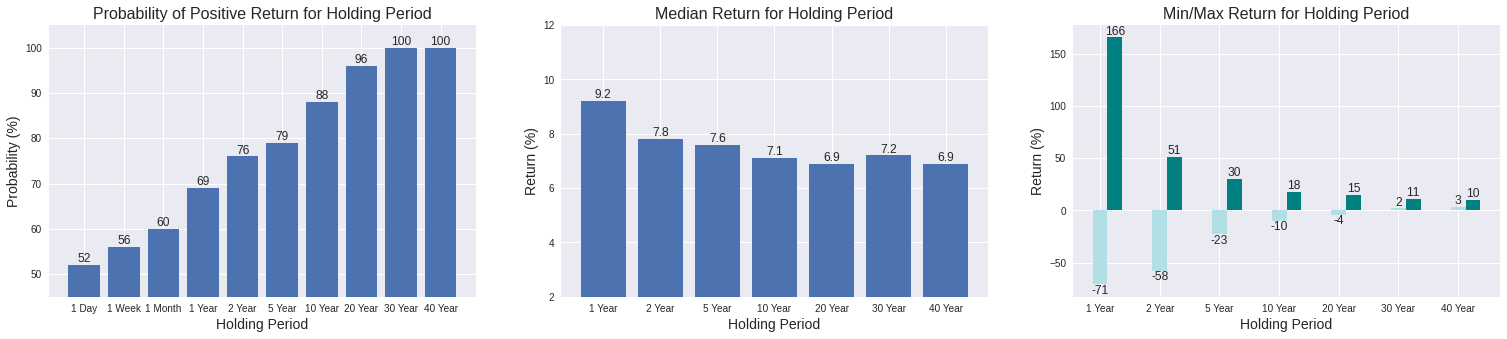

In [ ]:
period_prob = []
period_median = []
period_min = []
period_max = []

for tag in tags:
  prob = round((sum(period_return[tag] > 0) / period_return[tag].count())*100)
  median = round(period_return[tag].median()*100,1)
  max = round(period_return[tag].max()*100)
  min = round(period_return[tag].min()*100)
  period_prob.append(prob)
  period_median.append(median)
  period_min.append(min)
  period_max.append(max)

fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, figsize=(26, 5))

rect = ax1.bar(x=tags, height=period_prob)
ax1.set_ylabel('Probability (%)', fontsize=14)
ax1.set_xlabel('Holding Period', fontsize=14)
ax1.set_ylim(45, 105)
ax1.set_title('Probability of Positive Return for Holding Period', fontsize=16)
ax1.bar_label(rect, fontsize=12)

rect2 = ax2.bar(x=tags[3:], height=period_median[3:])
ax2.set_ylabel('Return (%)', fontsize=14)
ax2.set_xlabel('Holding Period', fontsize=14)
ax2.set_ylim(2, 12)
ax2.bar_label(rect2, fontsize=12)
ax2.set_title('Median Return for Holding Period', fontsize=16)

width = 0.25
x_axis = np.arange(len(period_min[3:]))
rect3 = ax3.bar(x_axis, period_min[3:], width, color = '#B0E0E6')
rect4 = ax3.bar(x_axis+width, period_max[3:], width, color = '#008080')
ax3.set_ylabel('Return (%)', fontsize=14)
ax3.set_xlabel('Holding Period', fontsize=14)
ax3.set_xticks(x_axis,tags[3:])
ax3.bar_label(rect3, fontsize=12)
ax3.bar_label(rect4, fontsize=12)
ax3.set_title('Min/Max Return for Holding Period', fontsize=16)


At this point we can draw some conclusions:


1.   The longer you hold your investment, the higher the probability of having a possitive return (In the last 100 years, if you bought the index and held your stocks for more than 30 years you had possitive returns).

2.   In the long run the equity market tends to a 7% annual return.

3.   In the shorter terms the mean and median returns are higher because there is more volatility.

Interestingly enough timing doesnt seem to be as important a factor as the holding period.

Let's try one more graph, given that in the long run the market seems to be close to 7%, let's find out the probability of having a 6% or higher return for each holding period.

Text(0.5, 1.0, 'Probability of beating 6.0%')

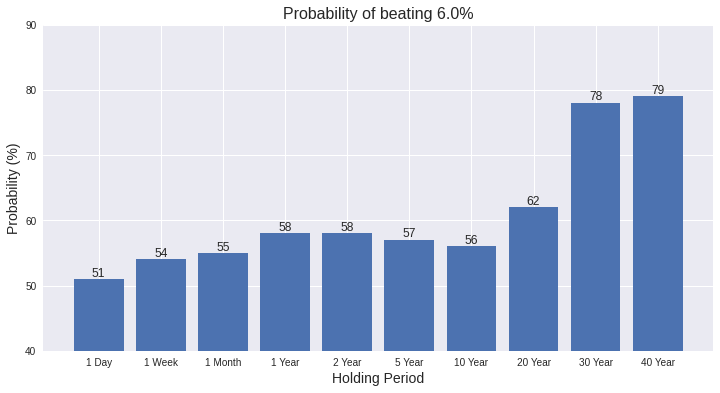

In [ ]:
thresh_prob = []
threshold = 0.06
for tag in tags:
  x = round((len(period_return[period_return[tag] > threshold]) / period_return[tag].count()) * 100)
  thresh_prob.append(x)

plt.figure(figsize=(12, 6))
rect = plt.bar(x=tags, height=thresh_prob)
plt.ylabel('Probability (%)', fontsize=14)
plt.xlabel('Holding Period', fontsize=14)
plt.bar_label(rect, fontsize=12)
plt.ylim(40,90)
plt.title(f"Probability of beating {threshold*100}%", fontsize=16)

So, here we can clearly see that, even though shorter periods have a higher mean, the best strategy for getting consistently a higher return is to hold your investments over time.

Now that we have a firmer grasp of how the market behaves, we will attempt to find strategies that beat buy & hold over the long run.

# **1. Pattern Trading**

Here we will attempt to find patterns of behavior in different time frames to search for a strategy that beats buy & hold (for example if on tuesdays the market always drops, we don't want to be invested on tuesdays).

To begin with we create a Dataframe with the daily returns of the index and the day of the week (where 0 is monday and 5 is friday) and perform a quick analysis through seaborn's catplot to see if further investigation would be usefull.

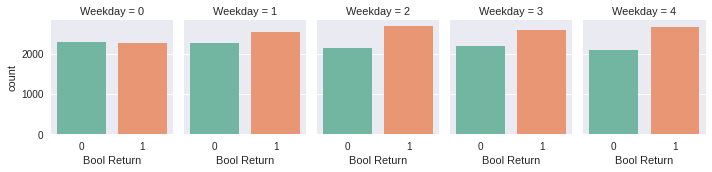

In [ ]:
daily = pd.DataFrame()
daily['Daily Return'] = df['Adj Close'].pct_change()
daily['Bool Return'] = np.where(daily['Daily Return'] < 0, 0, 1)
daily['Weekday'] = daily.index.weekday

#We only have 1 null value which is the first observation of 'Daily Return', this observation is inevitably lost because of how the column is constructed
daily.dropna(inplace=True)
g = sns.catplot(x='Bool Return', col='Weekday', data=daily, kind='count', height=2.5, aspect=.8, palette='Set2')

We can observe a couple of things:

> 1. There are more possitive (red) observations than negative ones (green).


> 2. There is a noticeable disparity in observations between days

Given this initial results we will search for further clues.

We will calculate the probability that the market will yield positive results on any given weekday.

We should also keep in mind that we are only searching for the % of possitive and negative days, we haven't dealt with the returns yet, so we will find the average return for each of the weekdays.

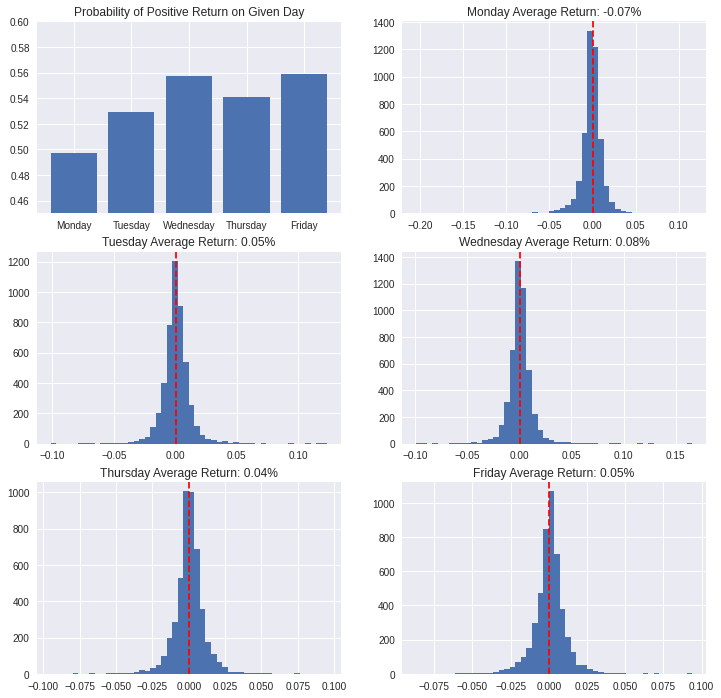

In [ ]:
possitive_p = []
days = ['Monday','Tuesday','Wednesday','Thursday','Friday']

#we iterate through each day and do (#of possitive observations / #of observations)
for i in range(0,len(days)):
  w = round(len(daily.loc[(daily['Weekday'] == i) & (daily['Bool Return'] == 1)]) / len(daily[daily['Weekday'] == i]),3)
  possitive_p.append(w)

weekday = {0:'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday'}

plt.figure(figsize=(12, 12))

plt.subplot(3,2,1)
plt.bar(x=days, height=possitive_p)
plt.ylim(0.45, 0.6)
plt.title('Probability of Positive Return on Given Day')

for i in range (0,5):
  plt.subplot(3,2,i+2)
  daily[daily['Weekday'] == i]['Daily Return'].hist(bins=50)
  plt.title(f"{weekday[i]} Average Return: {round(daily[daily['Weekday'] == i]['Daily Return'].mean()*100,2)}%")
  plt.axvline(x=daily['Daily Return'].mean(),color='r', linestyle='--')

I know, the axes on the first graph can be misleading, the probability of having a possitive return on any given day is close to 50% (which having only 2 possible outcomes is almost random), but there is a slight difference between wednesday and friday and the rest of the week and i think it's worth noting.

So, conclusions, wednesdays seem the best days because of the mean, however fridays appear to be the ones that consistently beat the market mean. Mondays are the worst ones, having the only negative mean.

This implies that there is a strategy worth exploring where you sistematically buy & hold mondays through fridays and never hold over the weekend.

We will first search for similar patterns on a monthly dimension, and then we will compare the three scenarios (buy & hold, trading the day of the week and trading the month).

In [ ]:
monthly = pd.DataFrame()
monthly['Return'] = df['Adj Close'].asfreq('BM').ffill().pct_change()
monthly['Month'] = monthly.index.month
monthly.dropna(inplace=True) #we drop the first observation wich becomes a null because of how the return is constructed
monthly.tail()

,Return,Month
Date,,
2022-01-31,-0.052585,1
2022-02-28,-0.031360,2
2022-03-31,0.035773,3
2022-04-29,-0.087957,4
2022-05-31,0.000053,5


We create the dataframe with the montly returns and the month number and now proceed to find the return distribution and mean return for each month.

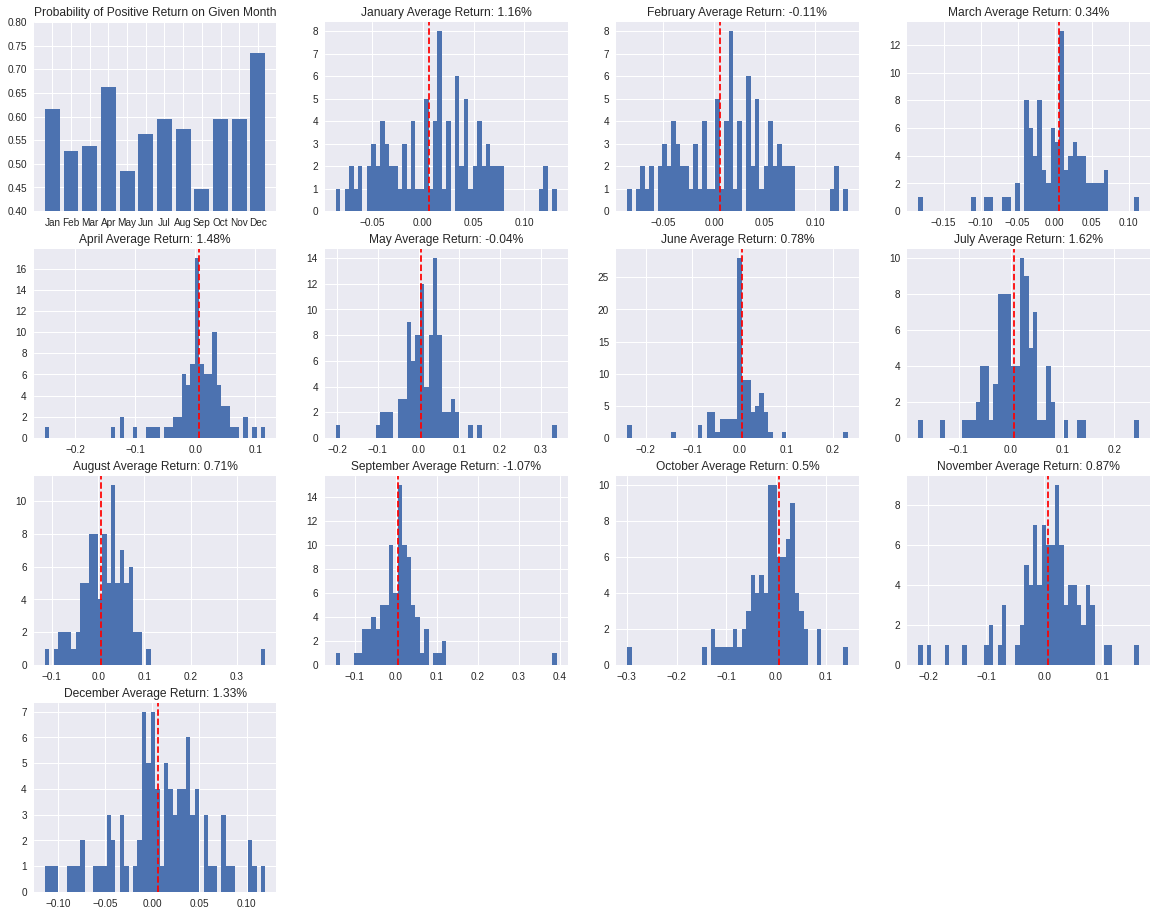

In [ ]:
possitive_p = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#we iterate through each day and do (#of possitive observations / #of observations)
for i in range(0,len(months)):
  w = len(monthly.query(f"Month == {i+1} & Return > 0")) / len(monthly[monthly['Month'] == (i+1)])
  possitive_p.append(w)

month = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

plt.figure(figsize=(20, 16))

plt.subplot(4,4,1)
plt.bar(x=months, height=possitive_p)
plt.ylim(0.4, 0.8)
plt.title('Probability of Positive Return on Given Month')

for i in range (0,len(months)):
  plt.subplot(4,4,i+2)
  if i == 0: #this if statement shouldn't be necessary, but when dioing january inside the loop the graph bugs and comes out empty.
    monthly[monthly['Month'] == 1]['Return'].hist(bins=50)
    plt.title(f"January Average Return: {round(monthly[monthly['Month'] == 1]['Return'].mean()*100,2)}%")
    plt.axvline(x=monthly['Return'].mean(),color='r', linestyle='--')
  else:
    monthly[monthly['Month'] == i]['Return'].hist(bins=50)
    plt.title(f"{month[i+1]} Average Return: {round(monthly[monthly['Month'] == i+1]['Return'].mean()*100,2)}%")
    plt.axvline(x=monthly['Return'].mean(),color='r', linestyle='--')

I think it is safe to say that the results are, at the very least, quite interesting.

The probability of a month being possitive is much more revealing than the daily one, for instance december has almost a 75% probability of being possitive.

When we look at the month's means and distributions we can see that there are clear diferences for each month.

December and january being good months may be explained because of the year end bonus that affects big players in funds and banks (no one wants a crisis to wipe your YTD performance and once the year is cleared you have more flexibility to build positions for the next year).

I can't really explain april and july's peak performance or september's poor one.

# **2. Comparing Strategies**

At this point i think we have enough information to see what happens if we alter our strategy to take into account market seasonality.

Basically in one Dataframe we will filter out monday's return* and in the other one we will filter out september, may and february.

*Keep in mind that if we take out mondays return it means selling the friday close and rebuying the monday close.

In [ ]:
#We start by excluding mondays from the observations
test_day = pd.DataFrame()
test_day['Return'] = df['Adj Close'].pct_change()
test_day['Weekday'] = test_day.index.weekday
test_day = test_day[~test_day['Weekday'].isin([0])]
test_day['Base'] =100 * np.cumprod(1 + test_day['Return'])


for i in range(0,len(tags)):
  test_day[tags[i]] =  test_day['Base'].pct_change(periods = periods[i])

test_day.drop(columns=['Return','Base','Weekday'],inplace=True)

for x in range(0,len(tags)):
  counter = 0
  for i in range(0, len(test_day)):
    if math.isnan(test_day.iloc[i,x]):
      pass
    else:
      test_day.iloc[i,x] = ((1 + test_day.iloc[i,x]) ** (365/(test_day.index[i]-test_day.index[counter]).days))-1
      counter += 1

#we make a second dataframe to exclude february, may and september from the observations
test_month = pd.DataFrame()
test_month['Return'] = df['Adj Close'].pct_change()
test_month['Month'] = test_month.index.month
test_month = test_month[~test_month['Month'].isin([2,5,9])]
test_month['Base'] =100 * np.cumprod(1 + test_month['Return'])


for i in range(0,len(tags)):
  test_month[tags[i]] =  test_month['Base'].pct_change(periods = periods[i])

test_month.drop(columns=['Return','Base','Month'],inplace=True)

for x in range(0,len(tags)):
  counter = 0
  for i in range(0, len(test_month)):
    if math.isnan(test_month.iloc[i,x]):
      pass
    else:
      test_month.iloc[i,x] = ((1 + test_month.iloc[i,x]) ** (365/(test_month.index[i]-test_month.index[counter]).days))-1
      counter += 1

That's a chunk of code so let me explain, we have to build two dataframes in which the return of a particular weekday or a particular month is not taken into account.

To achieve this i follow the next steps:

1.   Create a Dataframe(df) with the daily returns of the market.
2.   Filter the df to exclude the returns we do not want to take into account.
3.   Perform a base 100 of the returns (basically rebuild a price with only the returns i want to take into account*).
4.   Once i have this df i perform the same calculations i did at the beginning of this notebook, finding the returns over different time periods and annualizing them.


*Note that i am not taking into account the returns of the periods we mentioned earlier because i assume you sell the index and rebuy it later. However a much higher return could be achieved if we went short the index on those periods instead of merely selling. I am only selling because this analysis is meant for people who do not dedicate much time to the market, therefore this analysis only requires either 52 trades a year (exluding 1 day) or 3 trades a year (excluding 3 months).

Now that we have the dataframes we will simply search for the same metrics we did before, and then compare the 3 scenarios.

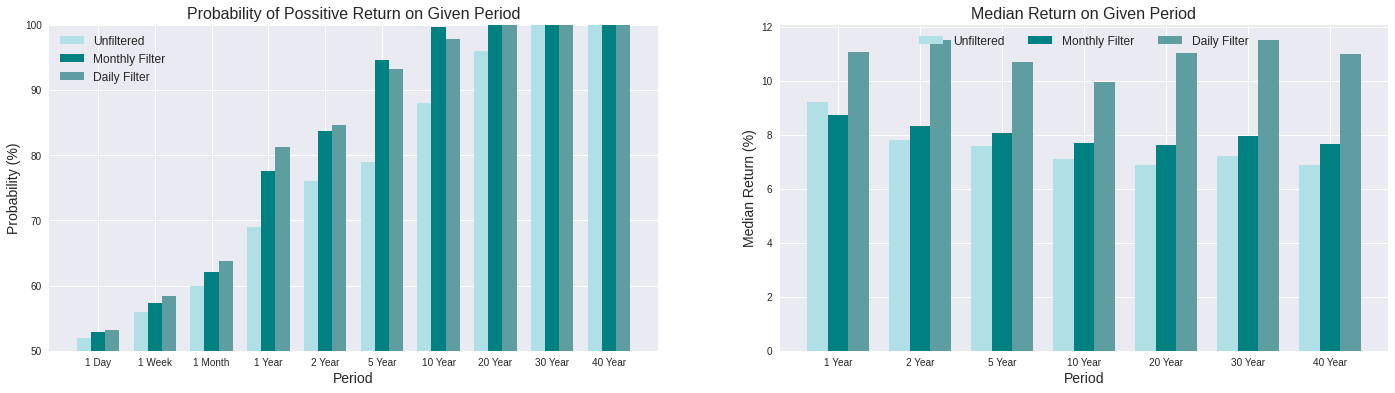

In [ ]:
#We create a list with the probability of possitive return and period median return for each of the dataframes 
daily_prob = []
daily_median = []

for tag in tags:
  x = (sum(test_day[tag] > 0) / test_day[tag].count())*100
  w = test_day[tag].median()*100
  daily_prob.append(x)
  daily_median.append(w)

monthly_prob = []
monthly_median = []

for tag in tags:
  x = (sum(test_month[tag] > 0) / test_month[tag].count())*100
  w = test_month[tag].median()*100
  monthly_prob.append(x)
  monthly_median.append(w)


#We make the graphs to compare and see our results
width = 0.25
x_axis = np.arange(len(tags))

plt.figure(figsize=(24, 6))
plt.subplot(1,2,1)
plt.bar(x_axis, period_prob, width, color = '#B0E0E6')
plt.bar(x_axis+width, monthly_prob, width, color = '#008080')
plt.bar(x_axis+width*2, daily_prob, width, color='#5F9EA0')

plt.xlabel("Period", fontsize=14)
plt.ylabel("Probability (%)", fontsize=14)
plt.title("Probability of Possitive Return on Given Period", fontsize=16)
plt.ylim(50,100)
plt.xticks(x_axis+width,tags)
plt.legend(('Unfiltered', 'Monthly Filter', 'Daily Filter') , fontsize=12)

x_axis = np.arange(len(tags[3:]))
plt.subplot(1,2,2)
plt.bar(x_axis, period_median[3:], width, color = '#B0E0E6')
plt.bar(x_axis+width, monthly_median[3:], width, color = '#008080')
plt.bar(x_axis+width*2, daily_median[3:], width, color='#5F9EA0')

plt.xlabel("Period", fontsize=14)
plt.ylabel("Median Return (%)", fontsize=14)
plt.title("Median Return on Given Period", fontsize=16)
plt.xticks(x_axis+width,tags[3:])
plt.legend(('Unfiltered', 'Monthly Filter', 'Daily Filter'), loc='upper center', ncol=3, fontsize=12)

# **Conclusion**

I think the graph is clear, excluding the returns mentioned earlier our strategies beat the buy & hold strategy consistently over time.

Clearly the daily strategy (selling the friday close and rebuying the monday close) is the superior one, lifting the median return from 7%ish to 11%ish, overtime this is HUGE considering that the only requirement is 1 weekly trade, that is 52 trades a year (assuming no monday holidays, if not even less).

I will stop the analysis here for the readers sake (i have already drone on far longer than i hoped to) but i would like to point out that combining both strategies (exluding the weekday as well as the months) will beat any strategy so far and as mentioned earlier going short on the weekday and the months would be even better.

We could also contemplate if the number of the week makes an impact (maybe the first week of the month should be excluded).

Finally i would like to mention that to be thorough with the analysis we should check if tendencies don't change with time, we could shorten our observations to the last 30 years for example and see if the same biases are there, if there is a difference we could then test the last 5 years of performance with the different strategies to see which one is the best one.

Note: of course if everyone starts 'trading' this market seasonality then the trend should dissapear over time.

# **3. Bull & Bear Markets**

By now, we have a better understanding of what to expect from the stock market, from mean returns and seasonality to return distributions and volatility.

We'll see how this ages but, as of now (june 2022) there is a debate of wether we are entering a bear* market or not, the market is roughly 20% down YTD (year to date) and people are wondering how much further can it fall.

I don't think we can precisely answer this questions. 

However i will attempt to:

1.   Show how are the yearly behaviours of the market.
2.   Understand the risk and rewards of bear and bull markets.

*a bear market makes reference to a general downwrad pattern in the price action of the stock market, a bull market makes reference to an upward pattern (the names are derived from the attacks of both animals, the bull thrusts it's horns upwards and the bear brings his paws downwards).

We begin by creating a dataframe with the monthly returns for each year and then another dataframe whith the cummulative returns for each month per year (we will exclude 2022 from the analysis because we only have observations for 5 months).

In [ ]:
monthly['Year'] = monthly.index.year
year = monthly.pivot(index='Month',columns='Year', values='Return')
year.drop([1928], axis=1, inplace=True)

year_accum = pd.DataFrame()
for col in year.columns:
  year_accum[col] = 1 * np.cumprod(1+ year[col])
  year_accum[col] -= 1
  year_accum[col] *= 100
year2022 = year_accum.pop(2022)
year_accum['Mean'] = year_accum.mean(axis=1)
year_accum.tail()

,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Mean
Month,,,,,,,,,,,,,,,,,,,,,
8,30.225867,-0.372960,-9.647982,3.325129,60.260116,-8.224680,18.315787,19.061798,-6.635619,14.312798,...,14.498772,8.386354,-4.211951,6.213980,10.399174,8.524426,16.738530,8.342568,20.409899,5.758772
9,23.860367,-13.333336,-36.701435,-0.492610,40.462430,-8.926784,22.000002,19.210721,-19.906869,16.018953,...,17.905056,6.704866,-6.744858,6.082864,12.530206,8.990461,18.744236,4.092509,14.682100,4.720077
10,-0.821358,-21.025641,-32.007821,-14.285713,29.479768,-11.634903,31.157895,28.294856,-28.114085,24.834122,...,23.163121,9.180574,0.993745,4.022132,15.027042,1.426157,21.170391,1.212708,22.611661,5.018795
11,-0.821358,-23.636370,-38.070405,-19.334972,29.479768,-4.312942,36.210522,28.667165,-35.331784,20.663501,...,26.617781,11.859166,1.044733,7.577039,18.257303,3.237563,25.295884,12.097693,21.589851,5.981010
12,-11.909649,-28.484850,-47.066494,-14.778323,44.075147,-4.714145,41.368424,27.922561,-38.591385,24.549764,...,29.601250,11.390634,-0.726600,9.535023,19.419966,-6.237260,28.878070,16.258923,26.892739,7.646809


We will now search for the min and max of the last row (being cummulative returns they will be the best and worst perfroming year in the dataframe).

Then we will graph the min, max, mean and current year, to better understand where we are standing.

Finally we will graph all recession years from 1928 to today to see if there is a recognizable pattern.

Text(0, 0.5, 'Cummulative Return')

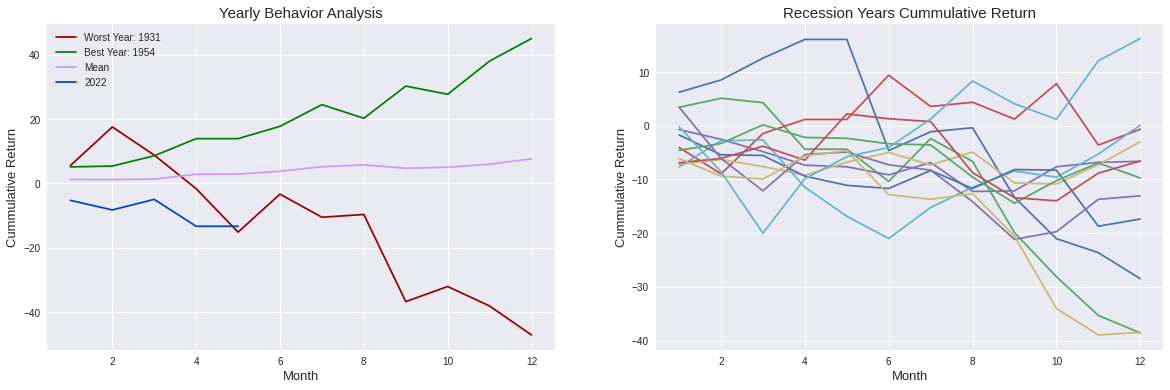

In [ ]:
recessions = [1930,1937,1948,1953,1960,1970,1973,1981,1990,2001,2008,2020]
min = year_accum.idxmin(axis=1)[12]
max = year_accum.idxmax(axis=1)[12]

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.plot(year_accum.index, year_accum[1931], color = '#990000')
plt.plot(year_accum.index, year_accum[1954], color = '#008000')
plt.plot(year_accum.index, year_accum['Mean'], color = '#cc99ff')
plt.plot(year_accum.index, year2022, color = '#0044cc')
plt.title('Yearly Behavior Analysis', fontsize=15)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Cummulative Return', fontsize=13)
plt.legend((f"Worst Year: {min}", f"Best Year: {max}", 'Mean','2022'))

plt.subplot(1,2,2)
for year in recessions:
  plt.plot(year_accum.index, year_accum[year])

plt.title('Recession Years Cummulative Return', fontsize=15)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Cummulative Return', fontsize=13)

I think we can agree nothing can be concluded from this, that is because even though recessions are known as year 'X' crisis they usually dont last an exact year, the maximum the market reaches is before the actual year of the crisis and the losses continue for a bit longer.

Let's try something else, i will now attempt to search the local minima and maxima around reccesion years to see how much does the market fall for each observation and on average.

Note: i know the selected years (1930,1937,1948,1953,1960,1970,1973,1981,1990,2001,2008,2020) might seem random, i chose them after reading research from different papers.

<AxesSubplot:xlabel='Date'>

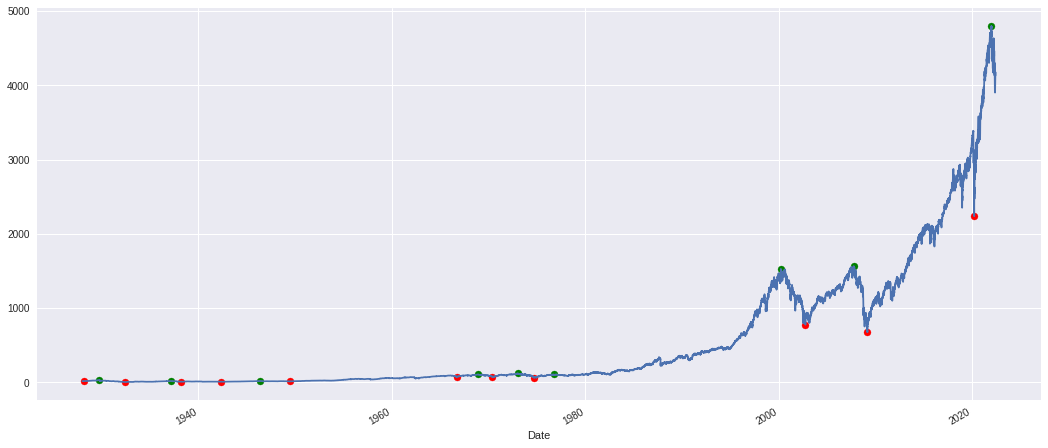

In [ ]:
data = pd.DataFrame()
data['price'] = df['Adj Close']
n = 650  # number of points to be checked before and after

# Find local peaks

data['min'] = data.iloc[argrelextrema(data.price.values, np.less, order=n)[0]]['price']
data['max'] = data.iloc[argrelextrema(data.price.values, np.greater, order=n)[0]]['price']

# Plot results
plt.figure(figsize=(18, 8))
plt.scatter(data.index, data['min'], c='r')
plt.scatter(data.index, data['max'], c='g')
data.price.plot()

Yes, we have a problem, some local points which are relevant are not getting picked up, so let's change the approach.

We will first search for the local minimum around the recession years and the following ones, once we have that we will take the date of the minimum observation and go back in time 2 years to find the local maximum where the crisis started. It's a bit overly complicated, but in some cases the market bounced back so quickly (2020 im looking at you) that the local maximum was after the minimum.

Text(0.5, 1.0, 'Length of Bull Market')

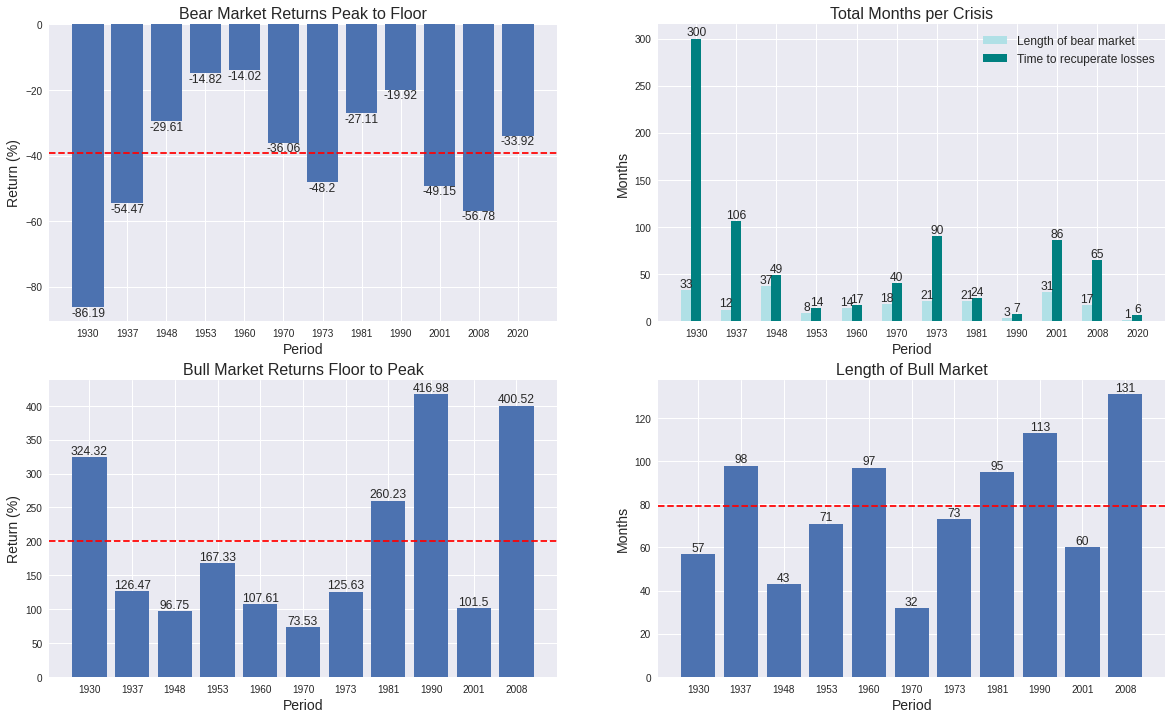

In [ ]:
bear_ret = []
bear_len = []
min_day = []
max_day = []
recuperation = []
n = 650

#First we find the local maximums and minimums (date and value) and we calculate the returns for each bear market
for year in recessions:
  minimum = data[data.index.year.isin([year,year+1,year+2])]
  finish = minimum.iloc[argrelextrema(minimum.price.values, np.less, order=n)].index[0]
  start = finish - pd.DateOffset(years=3)
  start = start - pd.DateOffset(months=6)
  maximum = data.loc[start : finish]
  percentage_lost = round((minimum.iloc[argrelextrema(minimum.price.values, np.less, order=n)]['price'][0] / maximum.iloc[argrelextrema(maximum.price.values, np.greater, order=n)]['price'][0] -1) *100,2)
  bear_ret.append(percentage_lost)
  max = maximum.iloc[argrelextrema(maximum.price.values, np.greater, order=n)].index[0]
  number_days = (finish.year - max.year)*12 + finish.month - max.month
  bear_len.append(number_days)
  min_day.append(finish)
  max_day.append(max)

#Here we find how many months did the market take to recuperate the losses
for day in max_day:
  x = data[(data.index > day) & (data.price >= data[data.index >= day]['price'][0])].index[0]
  count = (x.year - day.year)*12 + x.month - day.month
  recuperation.append(count)

#Here we calculate the returns and lengths of each bear market
bull_ret = []
bull_length = []
for i in range(0,len(min_day)-1):
  ret = round((data[data.index == max_day[i+1]]['price'][0] / data[data.index == min_day[i]]['price'][0] -1) *100,2)
  months = (max_day[i+1].year - min_day[i].year) *12 + max_day[i+1].month - min_day[i].month
  bull_ret.append(ret)
  bull_length.append(months)

fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(20,12))

dates = [str(i) for i in recessions]
rect=ax1.bar(x=dates, height=bear_ret)
ax1.set_ylabel('Return (%)', fontsize=14)
ax1.set_xlabel('Period', fontsize=14)
ax1.set_title('Bear Market Returns Peak to Floor', fontsize=16)
ax1.axhline(y=sum(bear_ret)/len(bear_ret),color='r', linestyle='--')
ax1.bar_label(rect, fontsize=12)


width = 0.25
x_axis = np.arange(len(bear_len))

rect1 = ax2.bar(x_axis, bear_len, width, color = '#B0E0E6')
rect2 = ax2.bar(x_axis+width, recuperation, width, color = '#008080')
ax2.set_xlabel("Period", fontsize=14)
ax2.set_ylabel("Months", fontsize=14)
ax2.set_title("Total Months per Crisis", fontsize=16)
ax2.legend(('Length of bear market', 'Time to recuperate losses'), fontsize=12)
ax2.set_xticks(x_axis+width,dates)
ax2.bar_label(rect1, fontsize=12)
ax2.bar_label(rect2, fontsize=12)


rect3=ax3.bar(x=dates[:-1], height=bull_ret)
ax3.set_ylabel('Return (%)', fontsize=14)
ax3.set_xlabel('Period', fontsize=14)
ax3.set_title('Bull Market Returns Floor to Peak', fontsize=16)
ax3.axhline(y=sum(bull_ret)/len(bull_ret),color='r', linestyle='--')
ax3.bar_label(rect3, fontsize=12)

rect4=ax4.bar(x=dates[:-1], height=bull_length)
ax4.set_ylabel('Months', fontsize=14)
ax4.set_xlabel('Period', fontsize=14)
ax4.bar_label(rect4, fontsize=12)
ax4.axhline(y=sum(bull_length)/len(bull_length),color='r', linestyle='--')
ax4.set_title('Length of Bull Market', fontsize=16)


I know, that was a bunch of code, im sory, we're almost done.

Let's take a quick look at the results, on average a bear market looses almost 40% of its value from its highest point and takes 67 months to get all the money back.

Sure 5.5 years might sound like a long time, however the probability of buying exactly on the peak or selling on the peak are close to 0.

The important thing here is that to recuperate a 40% loss you need a 66.6% possitive return, and bull markets on average have a 200% possitive return over time.

Bull markets have been both longer and stronger than bear markets in the past, which is why the market tendency overtime has been quite possitive. Past returns never guarantee future returns, but it gives us a solid idea of how much money we can loose and how long will we take to get it back.

This is why it's so important to keep emotions out of investing and why you should always aim to invest over a long time horizon, because then you can weather the storm and build wealth.

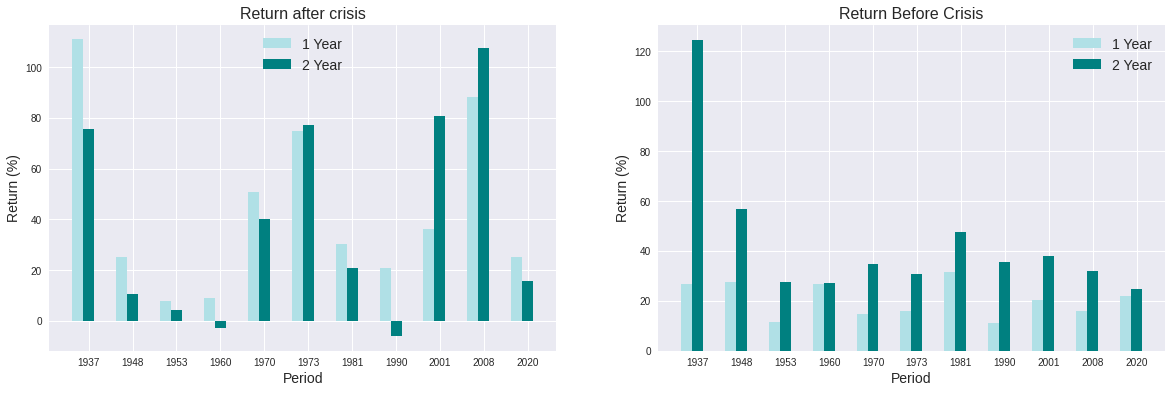

In [ ]:
year_return = []
year2_return = []
prev_year = []
prev2_year = []

for i in range(0, len(min_day)):
  y1 = round((data.iloc[data.index.get_loc(min_day[i] - pd.DateOffset(years=1),method='nearest')]['price'] / data[data.index == min_day[i]]['price'][0] -1) *100,2)
  year_return.append(y1)
  y2 = round((data.iloc[data.index.get_loc(min_day[i] - pd.DateOffset(years=2),method='nearest')]['price'] / data[data.index == min_day[i]]['price'][0] -1) *100,2)
  year2_return.append(y2)
  y_1 = round((data[data.index == max_day[i]]['price'][0] / data.iloc[data.index.get_loc(max_day[i] - pd.DateOffset(years=1),method='nearest')]['price'] -1) *100,2)
  prev_year.append(y_1)
  y_2 = round((data[data.index == max_day[i]]['price'][0] / data.iloc[data.index.get_loc(max_day[i] - pd.DateOffset(years=2),method='nearest')]['price'] -1) *100,2)
  prev2_year.append(y_2)

width = 0.25
x_axis = np.arange(len(year_return)-1)

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.bar(x_axis, year_return[1:], width, color = '#B0E0E6')
plt.bar(x_axis+width, year2_return[1:], width, color = '#008080')

plt.xlabel("Period", fontsize=14)
plt.ylabel("Return (%)", fontsize=14)
plt.title("Return after crisis", fontsize=16)
plt.legend(('1 Year', '2 Year'), fontsize=14)
plt.xticks(x_axis+width,dates[1:])

plt.subplot(1,2,2)
plt.bar(x_axis, prev_year[1:], width, color = '#B0E0E6')
plt.bar(x_axis+width, prev2_year[1:], width, color = '#008080')

plt.xlabel("Period", fontsize=14)
plt.ylabel("Return (%)", fontsize=14)
plt.title("Return Before Crisis", fontsize=16)
plt.xticks(x_axis+width,dates[1:])
plt.legend(('1 Year', '2 Year'), fontsize=14)

Finally i just wanted to show that it is VERY hard to guess wether a bear market is coming based on the returns of the past few years, and the returns after the crisis might be huge or might not.

There is almost no way to beat holding your investments over a long period of time and thinking of them as a retirement savings to be used in the future.

# **4. Conclusions and Final Remarks**

I would like to thank anybody who has read this far, i know i took a lot of your time.

I think the most important conclusion there is here is, the stock market is a very powerfull tool, with just $14.400 a year you can become a millionaire within 25 years as long as you are consistent, and understand that there will be years where you'll win or loose A TON of money. Remember "this too shall pass", stay consistent.

Finally i would like to explore a few more trading strategies that might be interesting.


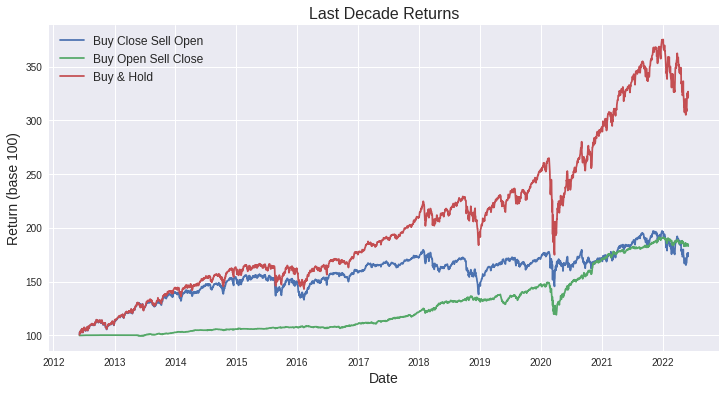

In [ ]:
#ver como es el retorno open vs close
#ver como es el retorno close vs open
#ver como es el retorno de la ultima decada si nos perdemos los mejores x dias de retorno
df[df.index > (datetime.today() - pd.DateOffset(years=10))]
df.drop(columns=['High','Low','Volume','Close'], inplace=True)
df['Close/Open'] = (df['Adj Close'] / df['Open'] -1)
df['Return'] = df['Adj Close'].pct_change()
df['Adj Close'] = df['Adj Close'].shift(+1)
df['Open/Close'] = (df['Open'] / df['Adj Close'] -1)
df.dropna(inplace=True)
df['Close/Open'] = 100* np.cumprod(1 + df['Close/Open'])
df['Open/Close'] = 100* np.cumprod(1 + df['Open/Close'])
df['Market'] = 100* np.cumprod(1 + df['Return'])

plt.figure(figsize=(12,6))
plt.plot(df.index,df['Close/Open'])
plt.plot(df.index,df['Open/Close'])
plt.plot(df.index,df['Market'])
plt.title('Last Decade Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Return (base 100)', fontsize=14)
plt.legend(('Buy Close Sell Open', 'Buy Open Sell Close','Buy & Hold'), fontsize=12)

I read a couple of times mentions of intraday trading strategies with open and close prices, they are not necesarily bad, but i thought it was worth showing that buy & hold beats everything.

When i started thinking about this notebook i wanted to test neural networks and machine learning on the stock market, but i wanted to do an introduction on market behaviour and traditional strategies. That ended up being the final point of the notebook.

Moving forward i would like to test an ARIMA model and an LSTM model to predict market movements, and see how this does against a random walk model. 

For now, i thank you again for reading all the way, i hope you found some interesting insights along the way.